In [ ]:
import sys
import numpy as np
import torch

# sys.path.insert(0,"..")
from dataloader import dataloader
tmp = dataloader(r"..\data\clover")
imu, rotor, mocap = tmp.runPipeline()
tmp.homogenizeData()
data = tmp.ConcatData


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]  Data folder c:\Users\aniru\Documents\01_UPenn\04_ESE6500\02_Homework\05_Project\DeepIO\data\clover\yawConstant\New folder\rosbag already exists. Not creating.


100%|██████████| 1/1 [00:12<00:00, 12.18s/it]


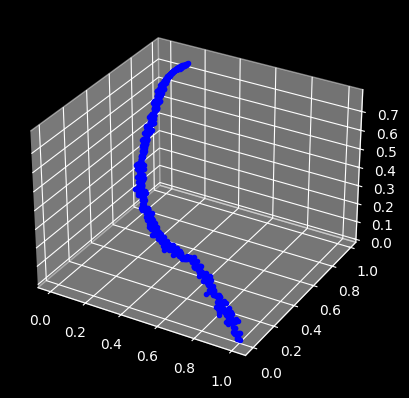

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

x1, y1, z1 = data['pose.position.x'].to_numpy(
), data['pose.position.y'].to_numpy(), data['pose.position.z'].to_numpy()
xA1, yA1, zA1 = data['psi'].to_numpy(
), data['theta'].to_numpy(), data['phi'].to_numpy()
t = data['Time'].to_numpy()
r1, r2, r3, r4 = data['rpm_0'].to_numpy(), data['rpm_1'].to_numpy(
), data['rpm_2'].to_numpy(), data['rpm_3'].to_numpy()

size = 1000
TrainSize = 800
St = 68000
t = t - t[St]

scaler_X = MinMaxScaler(feature_range=(0, 1))
xTrain = np.stack((r1[St:St + size], r2[St:St + size],
                  r3[St:St + size], r4[St:St + size], t[St:St + size]), axis=1)
yTrain = np.stack((x1[St:St + size], xA1[St:St + size], y1[St:St + size],
                  yA1[St:St + size], z1[St:St + size], zA1[St:St + size]), axis=1)

xTrain = scaler_X.fit_transform(xTrain)
yTrain = scaler_X.fit_transform(yTrain)

# torch.tensor(xTrain[:7000], dtype=torch.float32)
train_x = xTrain[:TrainSize]
# torch.tensor(yTrain[:7000], dtype=torch.float32)
train_y = yTrain[:TrainSize]
test_x = xTrain[TrainSize:]  # torch.tensor(xTrain[7000:], dtype=torch.float32)
test_y = yTrain[TrainSize:]  # torch.tensor(yTrain[7000:], dtype=torch.float32)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[:, 0], train_y[:, 1], train_y[:, 2], '.b')


In [ ]:
#### NODE #####

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt

method = 'dopri5'
batch_time = 45
batch_size = TrainSize-100
niters = 2000
test_freq = 100
viz = 'store_true'
adjoint = 'store_true'


def mini_batch(yTrain, xTrain, size, batch_size, batch_time):

    s = torch.from_numpy(np.random.choice(
        np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = xTrain[s, :4]
    batch_x = xTrain[:batch_time, 4]
    batch_y = torch.stack([torch.Tensor(xTrain[s + i, :4])
                          for i in range(batch_time)], dim=0)
    batch_yy = yTrain[s, :]
    batch_yy1 = yTrain[s+1, :]

    return batch_y0, batch_x, batch_y, batch_yy, batch_yy1


def TrainNODENetwork(yTrain, xTrain, size, batch_size, batch_time, FuncControl, FuncDynamics, niters=13000,):

    parameters = list(FuncControl.parameters()) + \
        list(FuncDynamics.parameters())
    # optimizerD = optim.Adam(params=parameters, lr=1e-3)
    optimizer = optim.Adadelta(
        params=parameters, lr=1, rho=0.9, eps=1e-06, weight_decay=0)

    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
            yTrain, xTrain, size, batch_size, batch_time)
        pred_y = odeint(FuncControl, torch.Tensor(
            batch_y0), torch.Tensor(batch_x))

        XDynamics = torch.cat((torch.Tensor(batch_y0), torch.Tensor(batch_yy)), 1).to(
            device='cuda:0')  # pred_y[1,:,:]
        pred_yy = FuncDynamics(XDynamics).to(device='cuda:0')
        lossD = torch.mean(
            torch.abs(pred_yy - torch.Tensor(batch_yy1).to(device='cuda:0')))
        # lossC = torch.mean(torch.abs(pred_y - torch.Tensor(batch_y)))

        loss = lossD  # + lossC
        loss.backward()
        optimizer.step()

        if itr % test_freq == 0:
            '''with torch.no_grad():
                pred_y = odeint(Func, torch.Tensor(y0[1,:]), t)
                loss = torch.norm(pred_y - torch.Tensor(y[:,1,:]))'''
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    return FuncControl, FuncDynamics


class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 4),
        )
        self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, t, y):
        return self.net(y)

    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)


class Func2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 75),
            nn.Tanh(),
            nn.Linear(75, 35),
            nn.Tanh(),
            nn.Linear(35, 6),
        )
        self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, y):
        return self.net(y)

    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)


FuncControl = ODEFunc()
FuncDynamics = Func2().to(device='cuda:0')

train_y = torch.tensor(train_y, device='cuda:0')
train_x = torch.tensor(train_x, device='cuda:0')


FuncControl, FuncDynamics = TrainNODENetwork(
    train_y, train_x, TrainSize, batch_size, batch_time, FuncControl, FuncDynamics)


Iter 0100 | Total Loss 0.070595
Iter 0200 | Total Loss 0.068764
Iter 0300 | Total Loss 0.057433
Iter 0400 | Total Loss 0.053471
Iter 0500 | Total Loss 0.037861
Iter 0600 | Total Loss 0.040660
Iter 0700 | Total Loss 0.041242
Iter 0800 | Total Loss 0.037232
Iter 0900 | Total Loss 0.032506
Iter 1000 | Total Loss 0.032612
Iter 1100 | Total Loss 0.033018
Iter 1200 | Total Loss 0.038095
Iter 1300 | Total Loss 0.029647
Iter 1400 | Total Loss 0.035588
Iter 1500 | Total Loss 0.024303
Iter 1600 | Total Loss 0.029294
Iter 1700 | Total Loss 0.025461
Iter 1800 | Total Loss 0.026543
Iter 1900 | Total Loss 0.031042
Iter 2000 | Total Loss 0.024877
Iter 2100 | Total Loss 0.025600
Iter 2200 | Total Loss 0.025629
Iter 2300 | Total Loss 0.023029
Iter 2400 | Total Loss 0.025332
Iter 2500 | Total Loss 0.020774
Iter 2600 | Total Loss 0.023241
Iter 2700 | Total Loss 0.025195
Iter 2800 | Total Loss 0.026480
Iter 2900 | Total Loss 0.024108
Iter 3000 | Total Loss 0.024859
Iter 3100 | Total Loss 0.023330
Iter 320

In [ ]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[:, 0], train_y[:, 1], train_y[:, 2], color='red')

y0 = train_y[0, :]
u0 = train_x[0, :4]
FuncDynamics.eval()
for i in range(TrainSize):

    # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))
    u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
    XDynamics = torch.cat(
        (torch.Tensor(u0), torch.Tensor(y0))).to(device='cuda:0')
    pred_y = FuncDynamics(XDynamics)
    y0 = pred_y.to('cpu').detach().numpy()
    ax.scatter(y0[0], y0[1], y0[2], s=8, c='b')
plt.show()
